In [2]:
%pip install tensorflow numpy matplotlib pillow scikit-learn opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import shutil
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
SOURCE_DIR = "food_dataset"
DEST_DIR   = "food_dataset_split"

TRAIN_RATIO = 0.7
VAL_RATIO   = 0.2
TEST_RATIO  = 0.1

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

random.seed(42)


In [5]:
classes = os.listdir(SOURCE_DIR)

for split in ["train", "val", "test"]:
    for cls in classes:
        Path(os.path.join(DEST_DIR, split, cls)).mkdir(parents=True, exist_ok=True)

print("✅ Folder structure created")


✅ Folder structure created


In [6]:
import os
import shutil
import random

SOURCE_DIR = "food_dataset"
DEST_DIR = "food_dataset_split"

TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

random.seed(42)

classes = [
    d for d in os.listdir(SOURCE_DIR)
    if os.path.isdir(os.path.join(SOURCE_DIR, d))
]

for split in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(DEST_DIR, split, cls), exist_ok=True)

for cls in classes:
    cls_path = os.path.join(SOURCE_DIR, cls)

    images = [
        img for img in os.listdir(cls_path)
        if os.path.isfile(os.path.join(cls_path, img))
    ]

    random.shuffle(images)

    total = len(images)
    train_end = int(total * TRAIN_RATIO)
    val_end = int(total * (TRAIN_RATIO + VAL_RATIO))

    for img in images[:train_end]:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(DEST_DIR, "train", cls, img)
        )

    for img in images[train_end:val_end]:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(DEST_DIR, "val", cls, img)
        )

    for img in images[val_end:]:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(DEST_DIR, "test", cls, img)
        )

print("✅ Dataset split completed successfully")


✅ Dataset split completed successfully


In [8]:
for split in ["train", "val", "test"]:
    print(f"\n{split.upper()}")
    for cls in classes:
        count = len(os.listdir(os.path.join(DEST_DIR, split, cls)))
        print(f"{cls}: {count}")



TRAIN
ApplePie: 65
BagelSandwich: 31
Bibimbop: 64
Bread: 62
FriedRice: 61
Pork: 62

VAL
ApplePie: 18
BagelSandwich: 9
Bibimbop: 18
Bread: 18
FriedRice: 18
Pork: 18

TEST
ApplePie: 10
BagelSandwich: 5
Bibimbop: 10
Bread: 10
FriedRice: 9
Pork: 9


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)


In [10]:
train_data = train_gen.flow_from_directory(
    f"{DEST_DIR}/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_data = val_gen.flow_from_directory(
    f"{DEST_DIR}/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_data = test_gen.flow_from_directory(
    f"{DEST_DIR}/test",
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)


Found 345 images belonging to 7 classes.
Found 99 images belonging to 7 classes.
Found 53 images belonging to 7 classes.


In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
import os

TRAIN_DIR = "food_dataset_split/train"

classes = [
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
]

print("✅ Classes detected in TRAIN folder:")
for cls in classes:
    print(" -", cls)

print("\nTotal classes:", len(classes))


✅ Classes detected in TRAIN folder:
 - .DS_Store
 - ApplePie
 - BagelSandwich
 - Bibimbop
 - Bread
 - FriedRice
 - Pork

Total classes: 7


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    "food_dataset_split/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_data = val_gen.flow_from_directory(
    "food_dataset_split/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_data = test_gen.flow_from_directory(
    "food_dataset_split/test",
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_data.num_classes
print("✅ Number of classes:", NUM_CLASSES)


Found 345 images belonging to 7 classes.
Found 99 images belonging to 7 classes.
Found 53 images belonging to 7 classes.
✅ Number of classes: 7


In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
EPOCHS = 15

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)



Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.1594 - loss: 2.2191 - val_accuracy: 0.2828 - val_loss: 1.7446
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3072 - loss: 1.8341 - val_accuracy: 0.4242 - val_loss: 1.5142
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3275 - loss: 1.7194 - val_accuracy: 0.5354 - val_loss: 1.3597
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4203 - loss: 1.4705 - val_accuracy: 0.6364 - val_loss: 1.2311
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4638 - loss: 1.3948 - val_accuracy: 0.6869 - val_loss: 1.1220
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5681 - loss: 1.2165 - val_accuracy: 0.6970 - val_loss: 1.0319
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6000 - loss: 1.1103 - val_accuracy: 0.7576 - val_loss: 0.9439
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6377 - loss: 1.0595 - val_accuracy: 0.7576 - val_loss:

In [16]:
loss, acc = model.evaluate(test_data)
print(f"✅ Test Accuracy: {acc*100:.2f}%")


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8113 - loss: 0.6528
✅ Test Accuracy: 81.13%


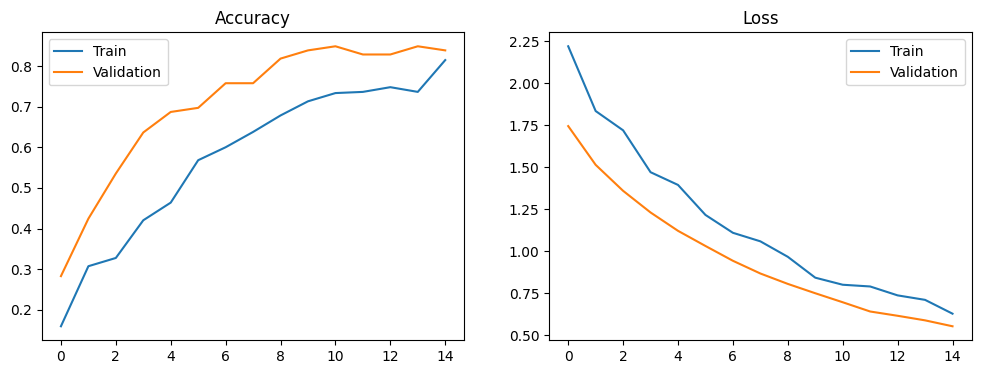

In [17]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(["Train", "Validation"])

plt.show()


In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class_names = list(train_data.class_indices.keys())

def predict_food(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    class_id = np.argmax(preds)
    confidence = preds[0][class_id]

    plt.imshow(load_img(image_path))
    plt.axis("off")
    plt.title(f"{class_names[class_id]} ({confidence*100:.2f}%)")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


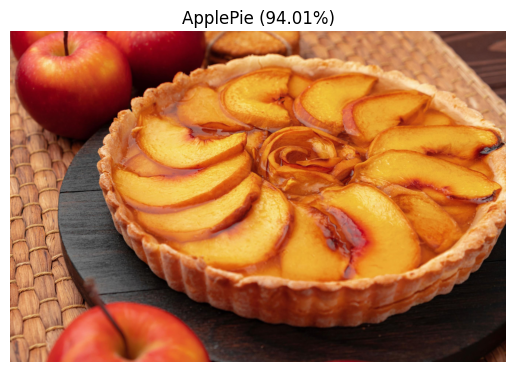

In [19]:
predict_food("Test_pictures/sample1.jpg")
